# Standard U-Net Model

It implements the standard U-Net model on the dataset of breast ultrasound images

# Import libraries

In [ ]:
import numpy as np
  
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, multiply, Lambda, add, Activation
from keras.layers import concatenate
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix 
from sklearn.model_selection import KFold

import os
from os import listdir

import natsort # it may need to be installed by 'pip install natsort'

import datetime
now = datetime.datetime.now

# Load the images

In [ ]:
# Directory with images and ground truths
path_imgs = "../Data/images/"
path_masks = "../Data/masks/"

imagesList = listdir(path_imgs)

# Sort the images in ascending order
imgList=natsort.natsorted(imagesList)

# Introduce parameters
img_row = 256
img_col = 256
img_chan = 1
epochnum = 200
batchnum = 4 
input_size = (img_row, img_col, img_chan)

num_imgs = len(imgList)
print("Number of images:", num_imgs)

Number of images: 510


In [ ]:
# Load the images 
def img_load(dir_path, imgs_list, imgs_array):
    for i in range(num_imgs):
        tmp_img = image.load_img(os.path.join(dir_path, imgs_list[i]), target_size=(img_row, img_col, img_chan))
        img = image.img_to_array(tmp_img)
        imgs_array[i] = img[:,:,0]/255.0 

    # Expand the dimensions of the arrays
    imgs_array = np.expand_dims(imgs_array, axis=3)
    return imgs_array

# Initialize the arrays
imgs = np.zeros((num_imgs, img_row, img_col))
masks = np.zeros_like(imgs)

imgs = img_load(path_imgs, imgList, imgs)
masks = img_load(path_masks, imgList, masks)

print("Images", imgs.shape)
print("Masks", masks.shape)

Images (510, 256, 256, 1)
Masks (510, 256, 256, 1)


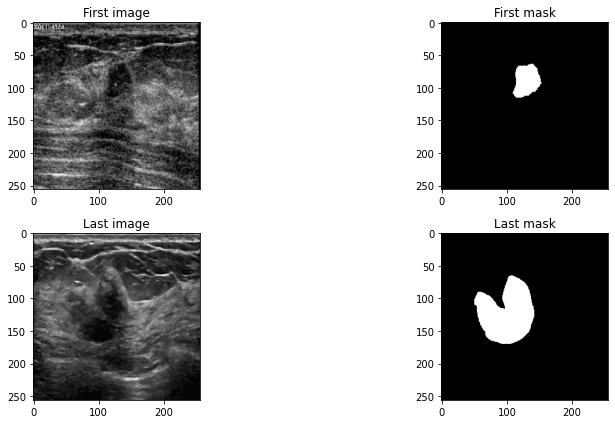

In [ ]:
# Plot the first and last images
plt.figure(figsize = (14,6))
plt.subplot(221)
plt.imshow(np.squeeze(imgs[0]), cmap = "gray")
plt.title('First image')
plt.subplot(222)
plt.imshow(np.squeeze(masks[0]), cmap = "gray")
plt.title('First mask')
plt.subplot(223)
plt.imshow(np.squeeze(imgs[-1]), cmap = "gray")
plt.title('Last image')
plt.subplot(224)
plt.imshow(np.squeeze(masks[-1]), cmap = "gray")
plt.title('Last mask')
plt.tight_layout()
plt.show()

# Performance metrics

In [ ]:
# Define loss and performance metrics
# Partially from Abraham and Khan (2019) - A Novel Focal Tversly Loss Function for Lesion Segmentation

# Dice score coefficient and Dice loss 
def dsc(y_true, y_pred):
    smooth = 1.
    # masks
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth) 
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

# Performance metrics: Dice score coefficient, IOU, recall, sensitivity
def auc(y_true, y_pred):
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1)) # ground truth
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + K.epsilon()) / (tp + fn + K.epsilon()) #recall
    tnr = (tn + K.epsilon()) / (tn + fp + K.epsilon())
    prec = (tp + K.epsilon()) / (tp + fp + K.epsilon()) #precision
    iou = (tp + K.epsilon()) / (tp + fn + fp + K.epsilon()) #intersection over union
    dsc = (2*tp + K.epsilon()) / (2*tp + fn + fp + K.epsilon()) #dice score
    return [dsc, iou, tpr, prec]

In [ ]:
# Convolutional block for UNet
def ConvBlock(in_fmaps, num_fmaps):
    # Inputs: feature maps for UNet, number of output feature maps
    conv1 = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(in_fmaps)
    conv_out = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(conv1)
    return conv_out

# Network

In [ ]:
# Build the model
def Network():
    
    input = Input(shape=input_size)

    conv1 = ConvBlock(input, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = ConvBlock(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = ConvBlock(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = ConvBlock(pool3, 64)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = ConvBlock(pool4, 128)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = ConvBlock(up6, 64)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = ConvBlock(up7, 64)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = ConvBlock(up8, 32)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = ConvBlock(up9, 32)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs = input, outputs = conv10)

    return model  

# Training and cross-validation

Run # 1
Training time: 0:04:18.953284


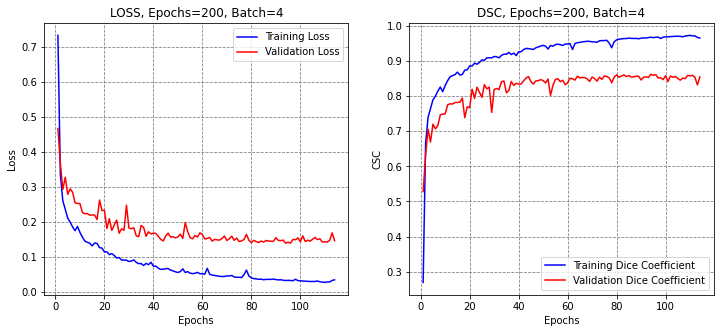

Testing time: 0:00:01.573764
------------------------------
USING THRESHOLD 0.5

 DSC 		0.899 
 IOU 		0.827 
 Recall 	0.915 
 Precision	0.898
 Global Acc 	0.977
 AUC ROC 	0.950


************************************************************
Run # 2
Training time: 0:03:19.629348


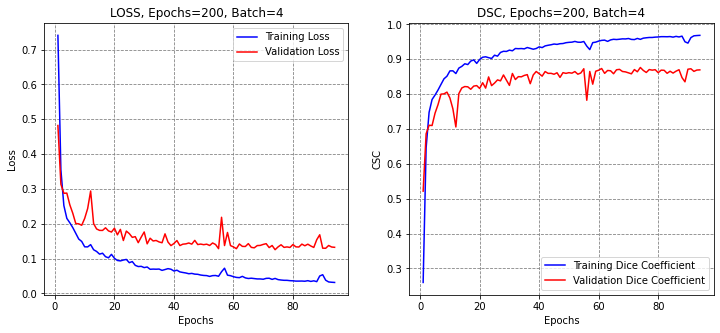

Testing time: 0:00:00.440311
------------------------------
USING THRESHOLD 0.5

 DSC 		0.892 
 IOU 		0.815 
 Recall 	0.901 
 Precision	0.903
 Global Acc 	0.976
 AUC ROC 	0.949


************************************************************
Run # 3
Training time: 0:02:33.117377


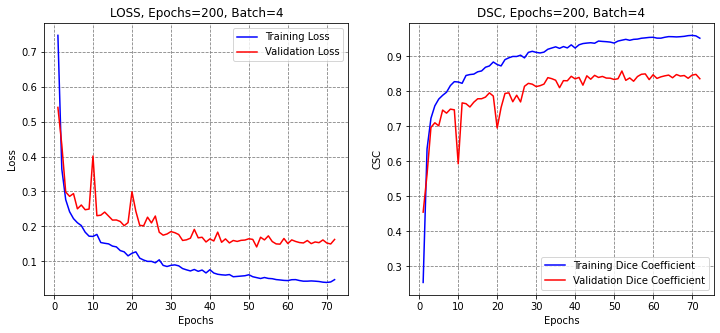

Testing time: 0:00:00.423423
------------------------------
USING THRESHOLD 0.5

 DSC 		0.909 
 IOU 		0.839 
 Recall 	0.904 
 Precision	0.925
 Global Acc 	0.979
 AUC ROC 	0.959


************************************************************
Run # 4
Training time: 0:03:09.140006


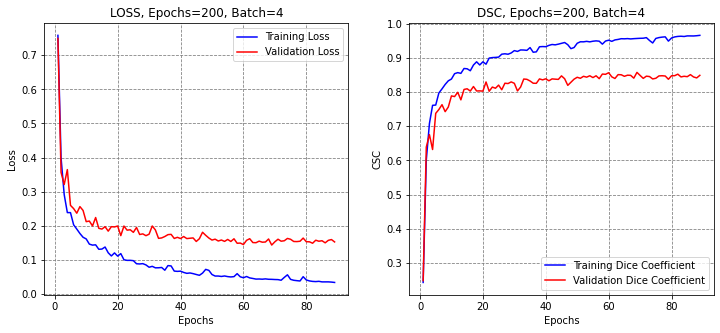

Testing time: 0:00:00.426096
------------------------------
USING THRESHOLD 0.5

 DSC 		0.902 
 IOU 		0.830 
 Recall 	0.921 
 Precision	0.898
 Global Acc 	0.977
 AUC ROC 	0.949


************************************************************
Run # 5
Training time: 0:03:46.884459


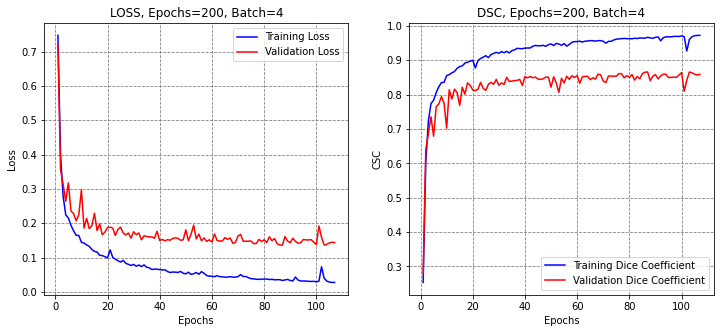

Testing time: 0:00:00.433726
------------------------------
USING THRESHOLD 0.5

 DSC 		0.867 
 IOU 		0.793 
 Recall 	0.898 
 Precision	0.865
 Global Acc 	0.978
 AUC ROC 	0.937


************************************************************


In [ ]:
# Evaluate the models using using k-fold cross-validation
n_folds = 5

numepochs = np.zeros(n_folds,)
dice_score = np.zeros(n_folds,)
iou_score = np.zeros_like(dice_score)
rec_score = np.zeros_like(dice_score)
prec_score = np.zeros_like(dice_score)
globacc_score = np.zeros_like(dice_score)
auc_roc_score = np.zeros_like(dice_score)

# Prepare cross-validation
kfold = KFold(n_folds, shuffle=True, random_state=1)

run = 0;
# enumerate splits
for train_ix, test_ix in kfold.split(imgs):
    
    # Display the run number
    print('Run #', run+1)
    
    # Define  the model
    model = Network()
    
    # Split into train and test sets
    imgs_train, masks_train, imgs_test, masks_test = imgs[train_ix], masks[train_ix], imgs[test_ix], masks[test_ix]
  
    # Compile and fit the  model
    model.compile(optimizer = Adam(lr = 0.0001), loss = dice_loss, metrics = [dsc])

    t = now()
    callbacks = [EarlyStopping(monitor='val_loss', patience = 20)]
    history = model.fit(imgs_train, masks_train, validation_split=0.15, batch_size=batchnum, 
                        epochs=epochnum, verbose=0, callbacks=callbacks)
    
    print('Training time: %s' % (now() - t))
    
    # Plot the loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['dsc'] 
    val_acc = history.history['val_dsc']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(122)
    plt.plot(epochsn, acc, 'b', label='Training Dice Coefficient')
    plt.plot(epochsn, val_acc, 'r', label='Validation Dice Coefficient')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('DSC, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('CSC')
    plt.show()
    
    # Make predictions
    t = now()
    preds = model.predict(imgs_test)
    print('Testing time: %s' % (now() - t))
    
    # Evaluate model
    num_test = len(imgs_test)
    # Calculate performance metrics
    dsc_sc = np.zeros((num_test,1))
    iou_sc = np.zeros_like(dsc_sc)
    rec_sc = np.zeros_like(dsc_sc)
    tn_sc = np.zeros_like(dsc_sc)
    prec_sc = np.zeros_like(dsc_sc)
    thresh = 0.5
    for i in range(num_test):
        dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(masks_test[i], preds[i] >thresh)
    print('-'*30)
    print('USING THRESHOLD', thresh)
    print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
            np.sum(dsc_sc)/num_test,  
            np.sum(iou_sc)/num_test,  
            np.sum(rec_sc)/num_test,
            np.sum(prec_sc)/num_test ))
    
    '''
    # To plot a set of images with predicted masks uncomment these lines
    num_disp = 10
    j=1
    plt.figure(figsize = (14,num_disp*3))
    for i in range(num_disp):
        plt.subplot(num_disp,4,j)
        plt.imshow(np.squeeze(imgs_test[i]), cmap='gray')
        plt.title('Image')
        j +=1
        plt.subplot(num_disp,4,j)
        plt.imshow(np.squeeze(masks_test[i]),cmap='gray')
        plt.title('Mask')
        j +=1
        plt.subplot(num_disp,4,j)
        plt.imshow(np.squeeze(preds[i]))
        plt.title('Prediction')
        j +=1
        plt.subplot(num_disp,4,j)
        plt.imshow(np.squeeze(np.round(preds[i])), cmap='gray')
        plt.title('Rounded; IOU=%0.2f, Rec=%0.2f, Prec=%0.2f' %(iou_sc[i], rec_sc[i], prec_sc[i]))
        j +=1
    plt.tight_layout()
    plt.show()    
    '''

    # Confusion matrix
    confusion = confusion_matrix( masks_test.ravel(),preds.ravel()>thresh)
    accuracy = 0
    if float(np.sum(confusion))!=0:
        accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
    print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
    # Area under the ROC curve
    AUC_ROC = roc_auc_score(preds.ravel()>thresh, masks_test.ravel())
    print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
    print('\n')
    print('*'*60)
    
    # Save outputs 
    numepochs[run] = epochsn[-1]
    dice_score[run] = np.sum(dsc_sc)/num_test
    iou_score[run] = np.sum(iou_sc)/num_test
    rec_score[run] = np.sum(rec_sc)/num_test
    prec_score[run] = np.sum(prec_sc)/num_test
    globacc_score[run] = accuracy
    auc_roc_score[run] = AUC_ROC
    run +=1   

# Display the Results

In [ ]:
# Display the scores in a table
import pandas
from pandas import DataFrame
df = DataFrame({'Epochs Number': numepochs, 'Dice Score': dice_score, 'IOU Score': iou_score, 'Recall (Sensitivity)': rec_score, 'Precision': prec_score, 'Global Accuracy': globacc_score, 'AUC-ROC': auc_roc_score})
df

,Epochs Number,Dice Score,IOU Score,Recall (Sensitivity),Precision,Global Accuracy,AUC-ROC
0,114.0,0.899342,0.826638,0.915428,0.897514,0.977477,0.950307
1,94.0,0.891857,0.814645,0.901059,0.902863,0.975505,0.948597
2,72.0,0.908945,0.838600,0.903631,0.924879,0.978517,0.958579
3,89.0,0.902268,0.829705,0.921268,0.898289,0.977262,0.949107
4,107.0,0.867470,0.793098,0.897668,0.864619,0.978041,0.936927


In [ ]:
# Calculate mean values of the scores
numepochs_mean = np.mean(numepochs)
dice_mean = np.mean(dice_score)
iou_mean = np.mean(iou_score)
rec_mean = np.mean(rec_score)
prec_mean = np.mean(prec_score)
globacc_mean = np.mean(globacc_score)
auc_roc_mean = np.mean(auc_roc_score)

# Mean values of the scores
df2 = DataFrame({'Epochs Number Mean': numepochs_mean, 'Dice Score Mean': dice_mean, 'IOU Score Mean': iou_mean, 'Recall (Sensitivity) Mean': rec_mean, 'Precision Mean': prec_mean, 'Global Accuracy Mean': globacc_mean, 'AUC-ROC Mean': auc_roc_mean},index=[5])
df2

,Epochs Number Mean,Dice Score Mean,IOU Score Mean,Recall (Sensitivity) Mean,Precision Mean,Global Accuracy Mean,AUC-ROC Mean
5,95.2,0.893976,0.820537,0.907811,0.897633,0.977361,0.948703


In [ ]:
# Calculate standard deviations of the scores
dice_std = np.std(dice_score)
iou_std = np.std(iou_score)
rec_std = np.std(rec_score)
prec_std = np.std(prec_score)
globacc_std = np.std(globacc_score)
auc_roc_std = np.std(auc_roc_score)


# Standard deviations of the scores
df3 = DataFrame({'Dice Score STD': dice_std, 'IOU Score STD': iou_std, 'Recall (Sensitivity) STD': rec_std, 'Precision STD': prec_std, 'Global Accuracy STD': globacc_std, 'AUC-ROC STD': auc_roc_std}, index=[5])
df3

,Dice Score STD,IOU Score STD,Recall (Sensitivity) STD,Precision STD,Global Accuracy STD,AUC-ROC STD
5,0.014344,0.015717,0.009,0.019288,0.001026,0.006913
